In [199]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [200]:
# Load the dataset
file_path = "insurance_claims.csv"
df = pd.read_csv(file_path)


In [201]:
# Display dataset information
print("Dataset Preview:")
print(df.head())

Dataset Preview:
   months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... witnesses police_report_available total_claim_amount  \
0       466

In [202]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                

In [203]:
# Drop irrelevant columns (if they exist)
columns_to_drop = ["policy_number", "policy_bind_date", "policy_state"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [204]:
# Ensure fraud_reported exists before proceeding
if "fraud_reported" not in df.columns:
    raise KeyError("Column 'fraud_reported' not found in dataset")

In [205]:
# Identify numerical and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [206]:
# Apply Outlier Capping on Numerical Columns
def cap_outliers(df, columns):
    for col in columns:
        if col in df.columns:
            lower_bound = df[col].quantile(0.01)  # 1st percentile
            upper_bound = df[col].quantile(0.99)  # 99th percentile
            df[col] = np.clip(df[col], lower_bound, upper_bound)  # Capping outliers
    return df

df = cap_outliers(df, numeric_cols)

In [207]:
# Handle missing values
num_imputer = SimpleImputer(strategy="median")
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [208]:
# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

In [209]:
print(df.columns)  # Check available columns


Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved',
       ...
       'auto_model_RAM', 'auto_model_RSX', 'auto_model_Silverado',
       'auto_model_TL', 'auto_model_Tahoe', 'auto_model_Ultima',
       'auto_model_Wrangler', 'auto_model_X5', 'auto_model_X6',
       'fraud_reported_Y'],
      dtype='object', length=1201)


In [210]:
# Define features (X) and target variable (y)
X = df.drop(columns=["fraud_reported_Y"])  # Features
y = df["fraud_reported_Y"].astype(int)  # Target variabl

In [211]:
# Feature Selection using Feature Importance
model_temp = RandomForestClassifier(n_estimators=100, random_state=42)
model_temp.fit(X, y)
feature_importances = pd.Series(model_temp.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(20).index.tolist()  # Selecting top 20 features
X = X[selected_features]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [213]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [214]:
# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42, class_weight="balanced")
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [215]:
# Train Random Forest model with best parameters
best_params = random_search.best_params_
model = RandomForestClassifier(**best_params, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       random_state=42)

In [217]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [218]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Model Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       151
           1       0.57      0.49      0.53        49

    accuracy                           0.79       200
   macro avg       0.71      0.69      0.69       200
weighted avg       0.78      0.79      0.78       200



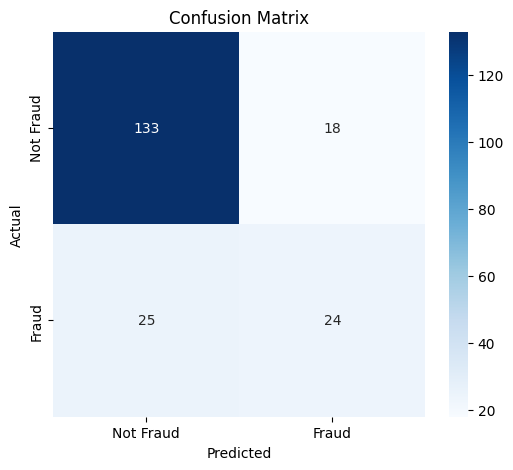

In [219]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


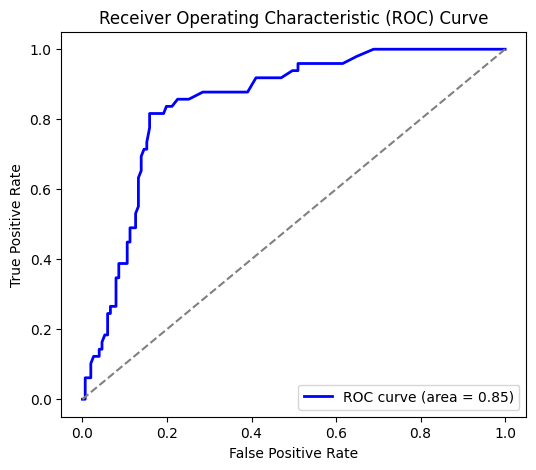

In [220]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
